|                                        |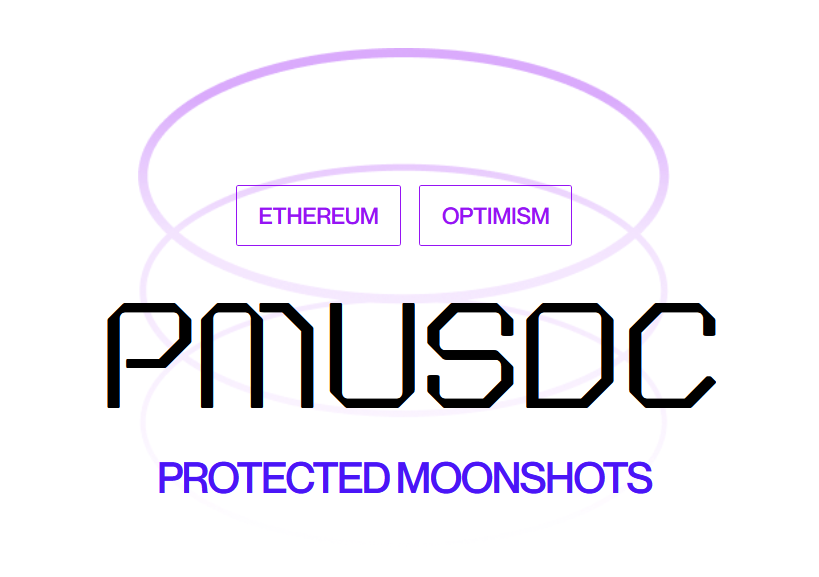|                                  |
|----------------------------------------|                                                             |----------------------------------|
# PMUSDC_v2 Main Vault

## Core idea

Following on from Brahma's first DegenVault, The Protected Moonshot USDC DegenVault, the next natural product extension was to provide an improvement in an existing signalling logic and introduce a diversification in tradable assets.

The core strategy idea is updated by utilizing the Trend Scanning labeling approach introduced by prof Marcos Lopez de Prado in Machine Learning for Asset Managers, 2020 and introducing the option/perp trade switching mechanics based on the volatility conditions. Overall the base yield generation keeps the previous structure introduced in PMUSDC by depositing the USDC into certain Curve LP pools and the LP tokens are later staked on Convex. Weekly the yield generated is harvested and this yield is used to take leveraged bets on crypto asset prices with the aim  of enhancing the DeFi native yields without putting the initial capital at risk.

This notebook aims to serve as a demonstration  of multiple approaches both already implemented and novel against the proposed PMUSDCV2 strategy.

The notebook is structured as follows: First, the relevant data required for backtesting these strategies are imported and analysed for suitability. Then the performance of various  derivative based trading strategies are investigated. The key drivers of returns for the most promising strategies are then investigated which guide further strategy improvements. Finally these improved strategies are compared and contrasted with the base ones and conclusions  are presented.


## Implementation

### Imports

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime,timedelta,timezone
from typing import Callable

import sys
sys.path.append("../../")
from modules.protected_moonshot import utils
from modules.backtesting.protected_moonshot.option import run_option_backtest
from modules.backtesting.protected_moonshot.perp import run_perp_backtest
from modules.util.data_helpers import group_historical_data
from modules.util.quant_helpers import time_interpolation
sns.set(palette='deep')

###  Data

For this backtest we gather 1year of historical data consisting of:
 * Hourly history of Deribit's Volatility Index: ETH DVOL
 * FTX price history data for ETH
 * 1-week at-the-money ETH implied volatility data from Deribit - we are constrained to using historical options data from centralised exchanges such as Deribit since onchain options are such a new primitive there is not sufficient history to perform a robust backtest. 

In [2]:
hourly_prices = pd.read_csv('../pmusdc/data/backtest_pmusdc_v2_h.csv', index_col='time')
hourly_prices.index = pd.to_datetime(hourly_prices.index)

hourly_dvol = pd.read_csv('../pmusdc/data/backtest_pmusdc_v2_dvol_h.csv', index_col='time')
hourly_dvol.index = pd.to_datetime(hourly_dvol.index)


weekly_prices = hourly_prices.resample('7d',offset = '8h',label='right').agg({'open':'first','close':'last','high':'max','low':'min'})
weekly_prices.drop(index = weekly_prices.index[-1],axis=0,inplace=True)

weekly_dvol = hourly_dvol.resample('7d',offset = '8h',label='right').agg({'dvol_open':'first','dvol_close':'last'})
weekly_dvol.drop(index = [weekly_dvol.index[-1],weekly_dvol.index[0]],axis=0,inplace=True)
zero = weekly_prices.head(1).index

In [3]:
hourly_prices

,open,high,low,close
time,,,,
2021-03-19 08:00:00+00:00,1793.9,1817.4,1785.1,1807.9
2021-03-19 09:00:00+00:00,1808.1,1819.5,1799.0,1801.5
2021-03-19 10:00:00+00:00,1801.5,1814.9,1800.3,1812.5
2021-03-19 11:00:00+00:00,1812.5,1822.9,1807.6,1820.1
2021-03-19 12:00:00+00:00,1820.1,1829.3,1811.4,1814.2
...,...,...,...,...
2022-05-27 04:00:00+00:00,1766.0,1776.3,1739.8,1743.5
2022-05-27 05:00:00+00:00,1743.5,1757.4,1710.0,1734.3
2022-05-27 06:00:00+00:00,1734.3,1776.2,1721.0,1768.7


### Additional feature creation

For our weekly leveraged bets, initial systems determine  the trade direction based on a simple momentum strategy. In order to calculate this we need to additionally generate the simple moving average(SMA) on daily data and then combine all available information in our weekly dataframe. We also generate realised volatility for further trade return analysis.

The chosen hyperparameter for the model is the SMA window size. For the current example we assume the window size of 5 days based on the empirical experience. The window size for the realised is chosen to be 7 days to line up with the trade horizon.

In [4]:
# Generate data and then add to weeklyData Dataframe (the central price data input)
ma_window = '3d'
rv_window = '7d'

moving_avg = utils.create_moving_avg(hourly_prices,weekly_prices,ma_window)
rv_start,rv_end = utils.create_realised_vol(hourly_prices,weekly_prices,rv_window)

weekly_data = weekly_prices.copy()
weekly_data['price_change'] = weekly_data.close/weekly_data.open -1
weekly_data['moving_avg'] = moving_avg
weekly_data['realised_vol_start'] = rv_start
weekly_data['realised_vol_end'] = rv_end

# Don't have enough price data for signal calc at start of first week so drop
weekly_data.drop(index=weekly_data.index[0], 
                 axis=0, 
                 inplace=True)

In [5]:
weekly_data.head()

,open,close,high,low,price_change,moving_avg,realised_vol_start,realised_vol_end
time,,,,,,,,
2021-04-02 08:00:00+00:00,1630.3,1999.8,2020.0,1613.9,0.226645,1632.666667,0.830570,0.541933
2021-04-09 08:00:00+00:00,1999.8,2080.6,2160.7,1934.0,0.040404,1926.833333,0.541933,0.642502
2021-04-16 08:00:00+00:00,2080.6,2430.4,2555.7,2050.9,0.168125,2062.000000,0.642502,0.787578
2021-04-23 08:00:00+00:00,2430.2,2132.8,2648.8,1900.0,-0.122377,2429.100000,0.787578,1.802794
2021-04-30 08:00:00+00:00,2132.7,2777.8,2801.8,2106.0,0.302480,2338.466667,1.802794,0.851048


### Trend following signal generation

Trend scanning is a labeling method that does not require defining neither horizon, nor profit-taking or stop-loss barriers. The general idea is to identify trends and let them run for as long and as far as they may persist, without setting any barriers. To have a more educated bet on the side of the trade we are going  to be applying trend scanning onto hourly data.

We will also ensure that there's no duplicates in the data so that the obtained results would be accurate to real-life conditions.

In [6]:
ind = hourly_prices[hourly_prices.index.duplicated()].index
hourly_prices.drop(ind, axis=0, inplace=True)
print("Found: ", ind.shape[0], "duplicate lines")

# Print the residual duplicate lines (sghould be empty)
hourly_prices[hourly_prices.index.duplicated()]

Found:  0 duplicate lines


,open,high,low,close
time,,,,


In [7]:
tr_sc_labels = pd.read_pickle('../pmusdc/data/ts_label_h1.pkl')
tr_sc_labels2 = pd.read_pickle('../pmusdc/data/ts_label_h2.pkl')

In [8]:
tr_sc_labels

,t1,t,ret,bin
time,,,,
2021-03-19 08:00:00+00:00,NaT,NaN,NaN,NaN
2021-03-19 09:00:00+00:00,NaT,NaN,NaN,NaN
2021-03-19 10:00:00+00:00,NaT,NaN,NaN,NaN
2021-03-19 11:00:00+00:00,NaT,NaN,NaN,NaN
2021-03-19 12:00:00+00:00,NaT,NaN,NaN,NaN
...,...,...,...,...
2022-05-27 04:00:00+00:00,2022-05-27 03:00:00+00:00,-14.774052,0.012905,-1.0
2022-05-27 05:00:00+00:00,2022-05-27 04:00:00+00:00,-15.293835,0.005305,-1.0
2022-05-27 06:00:00+00:00,2022-05-27 05:00:00+00:00,-15.406777,-0.019449,-1.0


Actual signal generation is based on the t-value of the observation.

In [9]:
long_signals = (tr_sc_labels['t'] > 1) & (tr_sc_labels2['t'] > 1)

short_signals = (tr_sc_labels['t'] <= -1) & (tr_sc_labels2['t'] < -1)

In [10]:
# Import 1week atm IV data.
skew_data_raw = pd.read_csv('../pmusdc/data/skew_data_master.csv')
skew_data_raw['Date'] = pd.to_datetime(skew_data_raw['DateTime'],utc=True)
skew_data_raw.set_index('Date',inplace=True)
skew_data = skew_data_raw['7d_atm_iv']


weekly_skews = pd.DataFrame(index = weekly_dvol.index)
weekly_skews['close'] = time_interpolation(skew_data,weekly_skews.index).values
weekly_skews.head()

,close
time,
2021-04-02 08:00:00+00:00,77.36
2021-04-09 08:00:00+00:00,61.34
2021-04-16 08:00:00+00:00,60.44
2021-04-23 08:00:00+00:00,108.38
2021-04-30 08:00:00+00:00,74.53


## Initial backtest: Trend Scanning vs SMA

First we'll test the viability of the Trend Scanning-based signal versus the SMA signal based on the simple option/perp buying strategies.

__0. Create the general metrics calculation functions__

We're creating metric calculation functions such as Sharpe ratio and Maximum Drawdown.

In [11]:
def calculate_sharpe(weekly_ret: pd.Series) -> float:
    """
    Calculating the Sharpe ratio based on the provided weekly returns series.
    
    :param weekly_ret: (pd.Series) Time series of weekly returns.
    :returns: (float) The Sharpe ratio of the strategy.
    """
   
    weekly_sharpe = weekly_ret.mean() / weekly_ret.std()
    
    annualized_sharpe = np.sqrt(52) * weekly_sharpe
    
    return annualized_sharpe

def calculate_drawdown(weekly_ret):
    """
    Calculates the maximum drawdown of the strategy for the provided weekly returns series.
    
    :param weekly_ret: (pd.Series) Time series of weekly returns.
    :returns: (float) The maximum drawdown for the strategy.
    """
    weekly_ret_cum = (weekly_ret + 1).cumprod()
    
    window = 52
    rolling_max = weekly_ret_cum.rolling(52, min_periods=1).max()
    
    weekly_drawdown = weekly_ret_cum/rolling_max -1
    
    max_drawdown = weekly_drawdown.rolling(52, min_periods=1).min()
        
    return max_drawdown[-1]  

__1. General strategy parameters__

We're going to establish our general strategies parameters such as yield percentage, etc.

In [12]:
#Perp Strategy specific params
leverage = 8.0
mm_min = 0.0625 # maintanence margin required for perp protocol
take_profit = 0.20 # take profit for enhanced strat
stop_loss = 0.05 # stop loss for enhanced strat

#Option Strategy specific params
r = 0 # r used in option pricing formula
strike_rounding = True # whether to apply rounding to option strikes
otm_percentage = 0 # % OTM of strike to buy/sell
bid_offer_spread = 0.0 # IV data is mid volatilities, add vol spread to get traded vol


#General Parameters
capital = 100 #starting capital
base_yield = 0.08 # convex deposit yield
freq = 7 #interest harvest and trade frequency (days)
interest = capital*base_yield*freq/365

__2. Position calculation__ 

We'll calculate the positions based on SMA and TS signal side by side.

In [13]:
weekly_data_ts = weekly_data.copy()
weekly_data_sma = weekly_data.copy()

In [14]:
weekly_data_ts

,open,close,high,low,price_change,moving_avg,realised_vol_start,realised_vol_end
time,,,,,,,,
2021-04-02 08:00:00+00:00,1630.3,1999.8,2020.0,1613.9,0.226645,1632.666667,0.830570,0.541933
2021-04-09 08:00:00+00:00,1999.8,2080.6,2160.7,1934.0,0.040404,1926.833333,0.541933,0.642502
2021-04-16 08:00:00+00:00,2080.6,2430.4,2555.7,2050.9,0.168125,2062.000000,0.642502,0.787578
2021-04-23 08:00:00+00:00,2430.2,2132.8,2648.8,1900.0,-0.122377,2429.100000,0.787578,1.802794
2021-04-30 08:00:00+00:00,2132.7,2777.8,2801.8,2106.0,0.302480,2338.466667,1.802794,0.851048
...,...,...,...,...,...,...,...,...
2022-04-29 08:00:00+00:00,3019.6,2925.7,3041.1,2765.0,-0.031097,3063.333333,0.595862,0.720071
2022-05-06 08:00:00+00:00,2925.7,2729.3,2966.7,2686.0,-0.067129,2891.966667,0.720071,0.714250
2022-05-13 08:00:00+00:00,2729.2,2043.7,2745.0,1701.2,-0.251173,2829.366667,0.714250,1.573862


In [15]:
# Calculating the SMA position
weekly_data_sma['position'] = np.where(weekly_data.open > weekly_data.moving_avg,1,-1)

In [16]:
# Calculating the TS position
weekly_data_ts['position'] = 0
weekly_data_ts.loc[long_signals.shift(7*24).dropna(), 'position'] = 1
weekly_data_ts.loc[short_signals.shift(7*24).dropna(), 'position'] = -1   

Checking if we covered all of the timestamps with some type of a bet - long, short or none

In [17]:
weekly_data_sma.position.isna().value_counts()

False    61
Name: position, dtype: int64

In [18]:
weekly_data_ts.position.isna().value_counts()

False    61
Name: position, dtype: int64

__3. Running the backtests__

The first step is running the backtest for our current strategies based on the SMA signal:

In [19]:
perp_simple_sma, perp_alpha_sma = run_perp_backtest(weekly_data_sma,hourly_prices,freq,leverage,mm_min,interest,'USD','simple')

perp_enhanced_sma, perp_alpha_enhanced_sma = run_perp_backtest(weekly_data_sma,hourly_prices,freq,leverage,mm_min,interest,'USD','enhanced',take_profit,stop_loss)
option_buyer_sma,option_buyer_alpha_sma = run_option_backtest(weekly_data_sma,weekly_skews+bid_offer_spread/2,freq,interest,'USD',r,otm_percentage,'option_buyer',strike_rounding)


accuracy_sma = ((weekly_data_sma.position * weekly_data_sma.price_change) > 0 ).sum() / weekly_data_sma.shape[0]

In [20]:
store_sma = {'SignalAccuracy':accuracy_sma,
         'PerpSimple':perp_alpha_sma,
         'PerpEnhanced':perp_alpha_enhanced_sma,
         'OptionBuy':option_buyer_alpha_sma}

store_sma = pd.DataFrame.from_dict(store_sma,orient='index')
store_sma.rename(columns={0:'simple_moving_average'},inplace=True)

store_sma[['sharpe', 'mdd']] = 0
store_sma.iloc[1:, 1:] = [[round(calculate_sharpe(x), 3), round(calculate_drawdown(x), 3)] for x in [perp_simple_sma.perp_returns, perp_enhanced_sma.perp_returns, option_buyer_sma.option_returns]]

Next, we're going to test the results of the trend scanning signal for the regular perp, enhanced perp and option buying strategies:

In [21]:
perp_simple_ts, perp_alpha_ts = run_perp_backtest(weekly_data_ts,hourly_prices,freq,leverage,mm_min,interest,'USD','simple')

perp_enhanced_ts, perp_alpha_enhanced_ts = run_perp_backtest(weekly_data_ts,hourly_prices,freq,leverage,mm_min,interest,'USD','enhanced',take_profit,stop_loss)

option_buyer_ts,option_buyer_alpha_ts = run_option_backtest(weekly_data_ts,weekly_skews+bid_offer_spread/2,freq,interest,'USD',r,otm_percentage,'option_buyer',strike_rounding)
option_buyer_ts.option_returns.fillna(0, inplace=True)

accuracy_ts = ((weekly_data_ts.position * weekly_data_ts.price_change) > 0 ).sum() / weekly_data_ts.shape[0]

In [22]:
store_ts = {'SignalAccuracy':accuracy_ts,
         'PerpSimple':perp_alpha_ts,
         'PerpEnhanced':perp_alpha_enhanced_ts,
         'OptionBuy':option_buyer_alpha_ts}

store_ts = pd.DataFrame.from_dict(store_ts,orient='index')
store_ts.rename(columns={0:'trend_scanning_momentum'},inplace=True)

store_ts[['sharpe', 'mdd']] = 0
store_ts.iloc[1:, 1:] = [[round(calculate_sharpe(x), 3), round(calculate_drawdown(x), 3)] for x in [perp_simple_ts.perp_returns, perp_enhanced_ts.perp_returns, option_buyer_ts.option_returns]]

__4. Comparison__

Finally, let's compare the general metrics results for the TS and SMA strategies:

In [23]:
print('The results for the TS-based signal:\n')
store_ts

The results for the TS-based signal:



,trend_scanning_momentum,sharpe,mdd
SignalAccuracy,0.508197,0.000,0.000
PerpSimple,0.386305,0.375,-0.674
PerpEnhanced,1.964540,2.721,-0.240
OptionBuy,3.935274,2.003,-0.636


In [24]:
print('The results for the SMA-based signal:\n')
store_sma

The results for the SMA-based signal:



,simple_moving_average,sharpe,mdd
SignalAccuracy,0.639344,0.000,0.000
PerpSimple,-0.278982,-0.252,-0.715
PerpEnhanced,2.272982,2.663,-0.251
OptionBuy,3.725098,1.837,-0.501


The TS-based strategies display an increase in robustness across all of the simple strategies, which can be explicitly seen from the larger Sharpe ratio values and generally lower drawdowns.

To make it more visual let's compare the histograms of returns for the Option Buying strategies:

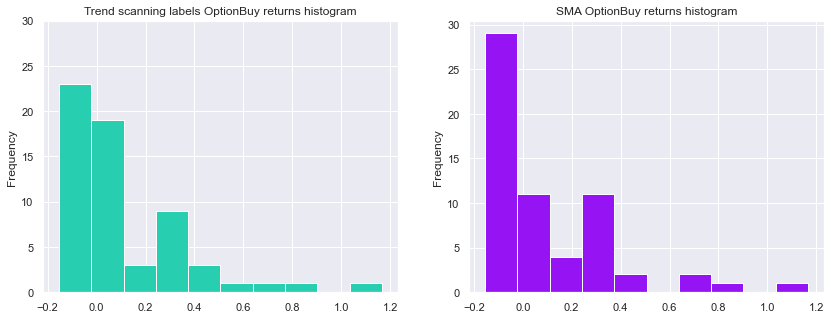

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

option_buyer_ts.option_returns.plot(kind='hist', color='#27CEAF', 
                                    ylim=(0,30), title='Trend scanning labels OptionBuy returns histogram',ax=axes[0]);

option_buyer_sma.option_returns.plot(kind='hist',color='#9614F4', title='SMA OptionBuy returns histogram', ax=axes[1]);

All of the TS signal-based strategies show much better results than the SMA-based signal both in terms of risk and return, providing lower drawdowns and higher values of Sharpe ratio.


## Further experiments on option strategies improvement

All further analysis is presented on strategies using the trend scanning signal to determine trade direction. Results for 100% accuracy and the static long only and short only signals were only shown above for illustration purposes.

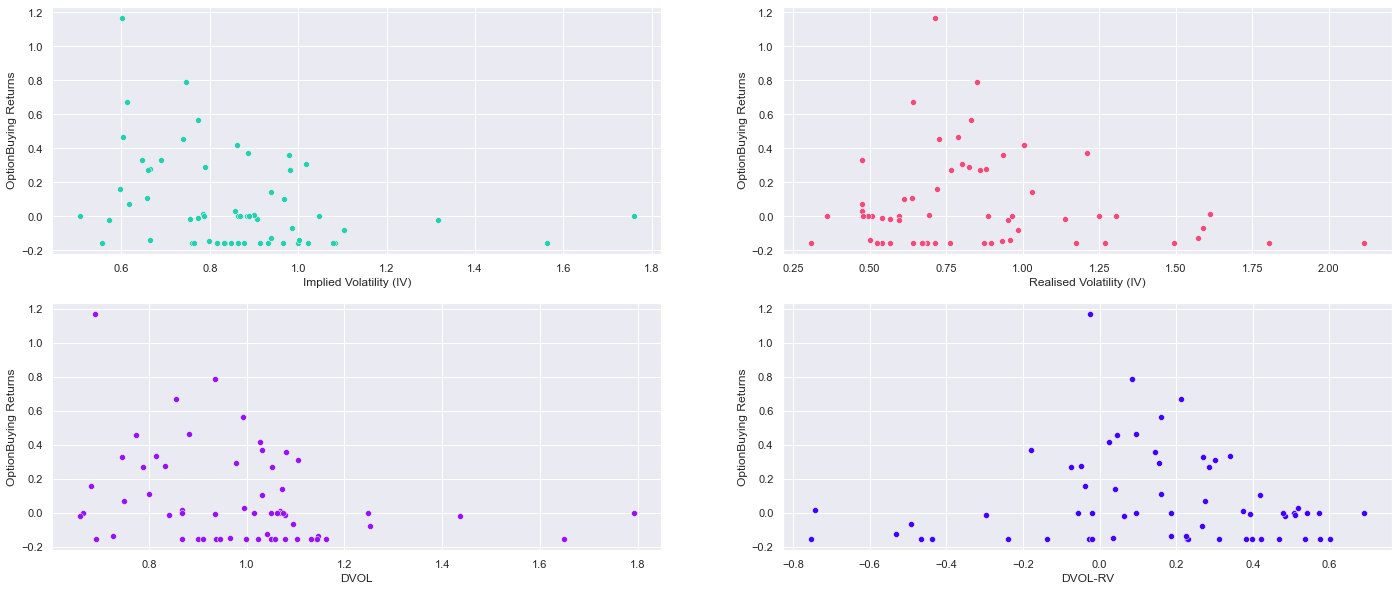

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,10))

# Plotting the absolute price move against the option buying strategy returns
sns.scatterplot(x=option_buyer_ts.sigma_open, y=option_buyer_ts.option_returns,
                ax=axes[0,0], color='#27CEAF');
axes[0,0].set_xlabel('Implied Volatility (IV)');
axes[0,0].set_ylabel('OptionBuying Returns');


# Plotting the Implied Volatility (IV) against the option buying strategy returns
sns.scatterplot(x=weekly_data_ts.realised_vol_start, y=option_buyer_ts.option_returns, 
                ax=axes[0,1], color='#EE4C7C');
axes[0,1].set_xlabel('Realised Volatility (IV)');
axes[0,1].set_ylabel('OptionBuying Returns');

# Plotting the DVOL-RV against the option buying strategy returns
sns.scatterplot(x=weekly_dvol.dvol_open/100, y=option_buyer_ts.option_returns,
                ax=axes[1,0], color='#9614F4');
axes[1,0].set_xlabel('DVOL');
axes[1,0].set_ylabel('OptionBuying Returns');

# Plotting the DVOL-RV against the enhanced perp strategy returns
sns.scatterplot(x=weekly_dvol.dvol_open/100 - weekly_data_ts.realised_vol_start,
                y=option_buyer_ts.option_returns, ax=axes[1,1], color='#4101FF');
axes[1,1].set_xlabel('DVOL-RV');
axes[1,1].set_ylabel('OptionBuying Returns');




### Test Volatility Regime Dependent Strategies
We then try 2 improved strategies to test how the strategy performs when filtering trading based on the volatility regime.
1. In weeks where the DVOL premium is too high, we don't take any trade. In all other weeks we purchase options (Options V2.0)

2. In weeks where the DVOL premium is too high, we use our current perp strategy. In all other weeks we purchase options (Options+Perp)

In [27]:
dvol_premium_threshold = 0.23
combined_strats = pd.concat([weekly_data_ts[['price_change','position']]
                          ,perp_enhanced_ts['perp_returns']
                          ,option_buyer_ts[['option_returns','sigma_open']]
                          ,weekly_data_ts.realised_vol_start
                          ,weekly_dvol.dvol_open/100]
                        ,axis=1)

combined_strats['dvol_premium'] = combined_strats['dvol_open']-combined_strats['realised_vol_start']

# First idea
combined_strats['optionsV2_0'] = np.where( (combined_strats['dvol_open'] > 1.2) ,0,combined_strats['option_returns'])

# Second idea - chosen for PMUSDCv2
combined_strats['options_perp'] = np.where(((combined_strats['sigma_open'] > 1.1)
                                            | (combined_strats['dvol_premium'] < -0.2)
                                            | (combined_strats['dvol_premium'] > 0.35)),
                                           combined_strats['perp_returns'],
                                           combined_strats['option_returns'])

# Best Case
combined_strats['best_case'] = combined_strats[['perp_returns','option_returns']].max(axis=1)

combined_strats['best_best_case'] = np.where(combined_strats['best_case'] > 0 , combined_strats['best_case'],0)

combined_strats['multi-strat'] = combined_strats['perp_returns']*0.5+0.5*combined_strats['option_returns']


num_weeks = combined_strats.shape[0]


improved_strat_results = pd.DataFrame.from_dict( {'Perp Imprv':perp_alpha_enhanced_ts,'Options Buyer':option_buyer_alpha_ts,
                         'Options Buyer++':combined_strats.optionsV2_0.sum()/(num_weeks/52),                                
                         'Options+Perp':combined_strats.options_perp.sum()/(num_weeks/52),
                         'BestCase':combined_strats.best_case.sum()/(num_weeks/52),
                                      
                         'Perfect Allocation':combined_strats.best_best_case.sum()/(num_weeks/52) } ,orient ='index')

improved_strat_results.rename(columns ={0:'Trading Alpha'},inplace=True)
yield_boost = (improved_strat_results.copy().rename(columns = {'Trading Alpha':'Base Yield Boost (x)'})/100+base_yield)/base_yield
test = pd.concat([improved_strat_results,yield_boost],axis =1)


strat_returns = combined_strats[['perp_returns','option_returns','optionsV2_0','options_perp','multi-strat']]

summary = pd.concat([strat_returns.sum() / (num_weeks/52),strat_returns.std()*np.sqrt(365/7)],axis=1)
summary['Sharpe'] = calculate_sharpe(strat_returns)
summary['Max Drawdown'] = [calculate_drawdown(strat_returns.iloc[:,x]) for x in range(strat_returns.shape[1])]
summary.rename(columns = {0:'Trading Alpha (%)',1:'Stddev Returns'},inplace=True)
summary.rename(index = {'perp_returns':'Perp+TS','option_returns':'Options+TS',
                       'optionsV2_0':'Options+TS++','options_perp':'PMUSDC V2'
                       },inplace=True)



In [28]:
round(test, 3)

,Trading Alpha,Base Yield Boost (x)
Perp Imprv,1.965,1.246
Options Buyer,3.935,1.492
Options Buyer++,4.151,1.519
Options+Perp,4.999,1.625
BestCase,5.949,1.744
Perfect Allocation,7.056,1.882


In [29]:
round((summary),3)

,Trading Alpha (%),Stddev Returns,Sharpe,Max Drawdown
Perp+TS,1.965,0.848,2.721,-0.240
Options+TS,3.935,1.968,2.003,-0.636
Options+TS++,4.151,1.952,2.129,-0.636
PMUSDC V2,4.999,1.942,2.807,-0.382
multi-strat,2.950,1.439,2.409,-0.440


### Plot Return Profiles

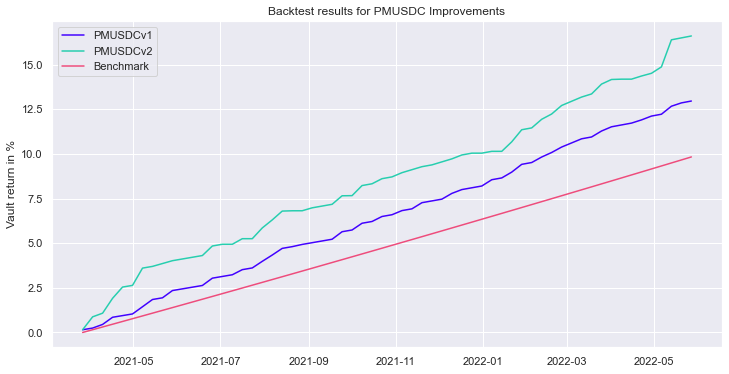

In [30]:
# Adjusting the general color scheme settings
import matplotlib as mpl
from cycler import cycler
font = {'family' : 'Sans',
        'weight' : 'normal',
        'size'   : 22}

mpl.rc('font', **font)
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#4101ff',
                                                '#27CEAF',
                                                '#ee4c7c'
                                               ] )

# Creating the figures 
plt.figure(figsize=(12,6))
perp_returns = pd.concat([pd.Series([0], index=zero),perp_enhanced_sma.perp_returns])
options_perp = pd.concat([pd.Series([0], index=zero),combined_strats.options_perp])
position = pd.concat([pd.Series([0], index=zero), abs(combined_strats.position.replace(to_replace=0, method='ffill'))])

# Plotting the graphs
plt.plot((((perp_returns.fillna(0)/100+base_yield/52)+1).cumprod()-1)*100)
plt.plot((((options_perp.fillna(0)/100+base_yield/52)+1).cumprod()-1)*100)
plt.plot(((1+base_yield/52*position).cumprod()-1)*100)

# Adjusting the plot details
plt.ylabel('Vault return in %')
plt.title('Backtest results for PMUSDC Improvements')
plt.legend(['PMUSDCv1', 'PMUSDCv2', 
            'Benchmark']);

# Conclusion

The below conclusions are drawn:

1. The Trend Scanning approach, results in a lot more robustness in returns as well as captures  the current trend well.

2. Using both options and PERP futures in the strategies bring the immense jump in projected revenue demonstrating a promising future application.

3. Adjusting option purchasing activities based on the volatility regime provides a significant boost to the trading returns generated resulting in base yields being enhanced by 1.6x without having to deployunderlying capital at further risk.
